In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import xgboost as xgb

In [3]:

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [4]:
df_raw2= pd.read_csv('df_raw2_train.csv') #import train and validation dataset of 3203 data points
df_raw2.head()

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,...,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
0,1.0,538.0,302.0,169.0,563.0,1000.0,1591.0,40000.0,309404152.0,686.0,...,0,0,0,0,0,1,0,0,0,0
1,2.0,1395.0,602.0,148.0,0.0,161.0,1794.0,11000.0,200074175.0,258.0,...,0,0,0,0,0,1,0,0,0,0
2,3.0,251.0,813.0,164.0,22000.0,23000.0,381.0,27000.0,448130642.0,1339.0,...,0,0,0,0,0,1,0,0,0,0
3,5.0,62.0,462.0,132.0,475.0,530.0,1836.0,640.0,73058679.0,323.0,...,0,0,0,0,0,1,0,0,0,0
4,6.0,1398.0,392.0,156.0,0.0,4000.0,880.0,24000.0,336530303.0,554.0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
df_raw3=df_raw2
df_raw3.drop(columns=['id','actor_1_name','actor_2_name','actor_3_name','director_name'], inplace=True)

In [6]:
df_imputed=df_raw3

In [7]:
useless_cols = ["id","imdb_score", 'actor_1_name','actor_2_name','actor_3_name','director_name']

In [8]:
train_cols = df_raw2.columns[~df_raw2.columns.isin(useless_cols)]
X_train = df_raw2[train_cols]
y_train = df_raw2["imdb_score"]

In [9]:
fake_valid_inds = np.random.choice(X_train.index.values, 600, replace = False)

train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

In [10]:
#XGBOOST transform data into DMatrix format for modeling
dtrain = xgb.DMatrix(X_train.loc[train_inds], y_train.loc[train_inds])
dvalid = xgb.DMatrix(X_train.loc[fake_valid_inds],  y_train.loc[fake_valid_inds])
type(dtrain)

xgboost.core.DMatrix

In [11]:
MAX_ROUNDS = 4000 #1000
EARLY_STOP = 500 #50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50
RANDOM_STATE = 2000

In [12]:
# # XGBoost Parameters 2 (inital)
# params = {}
# #params['objective'] = 'binary:logistic' #binary:hinge
# #params['objective'] = 'multi:softmax'
# params['objective'] = 'reg:linear'
# params['eta'] = 0.039
# params['silent'] = True
# params['max_depth'] = 2
# params['subsample'] = 0.8
# params['colsample_bytree'] = 0.9
# params['eval_metric'] = 'rmse'  #aucpr: Area under the PR curve
# params['random_state'] = RANDOM_STATE


# watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [19]:

# A parameter grid for XGBoost
#at least include the parameters already included in the baseline model for chance to find one better than base model.
# params = {
#         'min_child_weight': [1,2, 5],
#         'gamma': [0.5, 1, 2],
#         'subsample': [ 0.8,0.6],
#         'colsample_bytree': [0.9,0.6],
#         'max_depth': [2,3,4, 5,8,9,10,11,12,13,14,15],
#         'eta':[0.039,0.05, 0.1, 0.3, 0.5],
#         'objective':['reg:linear'],
#         'eval_metric':['rmse']
    
#         }


# params = {
#         'min_child_weight': [2, 5],
#         'gamma': [0.5, 1, 2],
#         'subsample': [ 0.8],
#         'colsample_bytree': [0.9],
#         'max_depth': [3,5,10],
#         'eta':[0.039, 0.1],
#         'objective':['reg:linear'],
#         'eval_metric':['rmse']
    
#         }

# # 4min 0.43117337118712257


params = {
        'min_child_weight': [1,2, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [ 0.8,0.6],
        'colsample_bytree': [0.9,0.6],
        'max_depth': [2,3,4, 5,8,9,10,11,12,15],
        'eta':[0.039,0.1, 0.5],
        'objective':['reg:linear'],
        'eval_metric':['rmse']
    
        }

In [20]:
#run all grid search will be 45 hours so randomized search
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from datetime import datetime

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

#random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

xgb_algo = xgb.XGBRegressor()
# random_search = RandomizedSearchCV(xgb_algo,
#                                    param_distributions=params, n_iter=param_comb, scoring='mse', n_jobs=4, cv=skf.split(X_train,y_train), verbose=50, random_state=2000)
xgb_grid = GridSearchCV(xgb_algo,
                        params,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
#random_search.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 2 folds for each of 1080 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   52.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  8.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 40.6min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 58.4min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 73.6min
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed: 88.7min finished


[19:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.

 Time taken: 1 hours 28 minutes and 45.33 seconds.


In [21]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

# 0.4553582517343139
# {'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'objective': 'reg:linear', 'subsample': 0.6}

0.4553582517343139
{'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'objective': 'reg:linear', 'subsample': 0.6}


In [22]:
# XGBoost Parameters 2
params = {}
#params['objective'] = 'binary:logistic' #binary:hinge
#params['objective'] = 'multi:softmax'
params['objective'] = 'reg:linear'
params['eta'] = 0.1
params['silent'] = True
params['max_depth'] = 4
params['subsample'] = 0.6
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'rmse'  #aucpr: Area under the PR curve
params['random_state'] = RANDOM_STATE
params['gamma']=0.5
params['min_child_weight']=1


watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [23]:
%%time

#m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

#xgb should use all data to train,should not exclude last 28 days ??

m_xgb = xgb.train(params,
                   dtrain,
                   MAX_ROUNDS,
                   watchlist,
                   early_stopping_rounds = EARLY_STOP,
                   maximize = True,
                   verbose_eval = VERBOSE_EVAL)

[0]	train-rmse:5.44085	valid-rmse:5.52995
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[50]	train-rmse:0.53456	valid-rmse:0.64813
[100]	train-rmse:0.40730	valid-rmse:0.63762
[150]	train-rmse:0.31695	valid-rmse:0.64240
[200]	train-rmse:0.25270	valid-rmse:0.64361
[250]	train-rmse:0.20975	valid-rmse:0.64343
[300]	train-rmse:0.18319	valid-rmse:0.64351
[350]	train-rmse:0.17299	valid-rmse:0.64326
[400]	train-rmse:0.16693	valid-rmse:0.64271
[450]	train-rmse:0.16495	valid-rmse:0.64311
[500]	train-rmse:0.16302	valid-rmse:0.64264
Stopping. Best iteration:
[0]	train-rmse:5.44085	valid-rmse:5.52995

Wall time: 12.4 s


In [24]:
useless_cols = ["id","imdb_score", 'actor_1_name','actor_2_name','actor_3_name','director_name'] 
# xgb does not take label encoded directly, need one hot encoded features. 
# so dropped 'actor_1_name','actor_2_name','actor_3_name','director_name'

train_cols = df_raw2.columns[~df_raw2.columns.isin(useless_cols)]

In [25]:
df_raw2_test=pd.read_csv('df_raw2_test.csv') #hold out dataset of 360


In [26]:
X_test=df_raw2_test[train_cols]
y_test=df_raw2_test["imdb_score"]


In [27]:
preds = m_xgb.predict(xgb.DMatrix(X_test))

In [28]:
import sklearn.metrics as metrics
import math
print('XGB - test rmse: ', math.sqrt(metrics.mean_squared_error(y_test, preds)))
#after tune 1
#0.7836648185163719
#base
# XGB - test rmse:  0.7592219053252504
# XGB - test rmse:  0.7565894072382466

XGB - test rmse:  0.7836648185163719


In [29]:
params = {
        'min_child_weight': [2, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [ 0.8],
        'colsample_bytree': [0.9],
        'max_depth': [3,5,10],
        'eta':[0.039, 0.1],
        'objective':['reg:linear'],
        'eval_metric':['rmse']
    
        }

In [30]:
#run all grid search will be 45 hours so randomized search
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from datetime import datetime

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

#random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

xgb_algo = xgb.XGBRegressor()
# random_search = RandomizedSearchCV(xgb_algo,
#                                    param_distributions=params, n_iter=param_comb, scoring='mse', n_jobs=4, cv=skf.split(X_train,y_train), verbose=50, random_state=2000)
xgb_grid = GridSearchCV(xgb_algo,
                        params,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
#random_search.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done  72 out of  72 | elapsed:  3.5min finished



 Time taken: 0 hours 3 minutes and 36.63 seconds.


In [33]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

# 0.43117337118712257
# {'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 1, 'max_depth': 10, 'min_child_weight': 5, 'objective': 'reg:linear', 'subsample': 0.8}

0.43117337118712257
{'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 1, 'max_depth': 10, 'min_child_weight': 5, 'objective': 'reg:linear', 'subsample': 0.8}


Text(0, 0.5, 'Feature Importance Score')

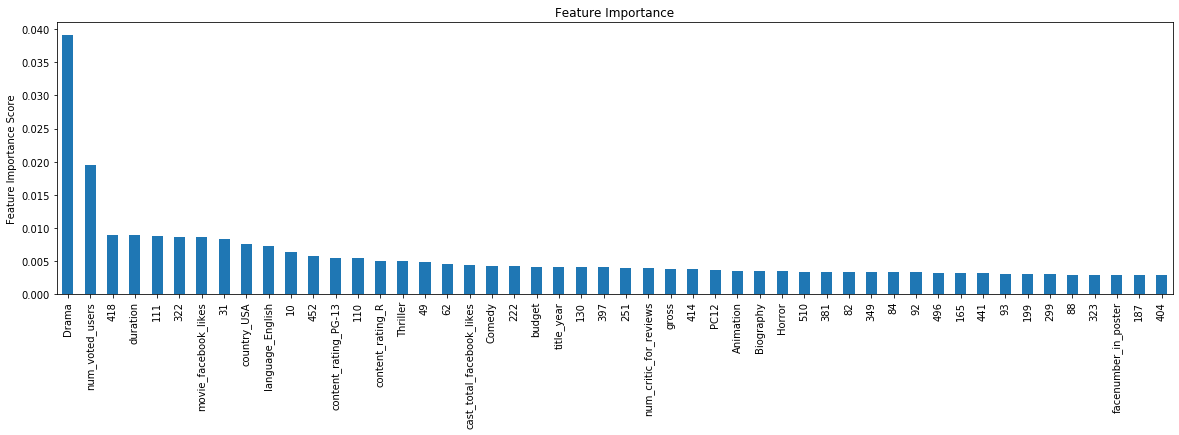

In [45]:
import matplotlib.pyplot as plt
#Feature importance for top 50 predictors
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(xgb_grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [13]:
# XGBoost Parameters 2
params = {}
#params['objective'] = 'binary:logistic' #binary:hinge
#params['objective'] = 'multi:softmax'
params['objective'] = 'reg:linear'
params['eta'] = 0.1
params['silent'] = True
params['max_depth'] = 10
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'rmse'  #aucpr: Area under the PR curve
params['random_state'] = RANDOM_STATE
params['gamma']=1
params['min_child_weight']=5


watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [14]:
%%time

#m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

#xgb should use all data to train,should not exclude last 28 days ??

m_xgb2 = xgb.train(params,
                   dtrain,
                   MAX_ROUNDS,
                   watchlist,
                   early_stopping_rounds = EARLY_STOP,
                   maximize = True,
                   verbose_eval = VERBOSE_EVAL)

[0]	train-rmse:5.44860	valid-rmse:5.48227
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[50]	train-rmse:0.25268	valid-rmse:0.70984
[100]	train-rmse:0.21978	valid-rmse:0.70588
[150]	train-rmse:0.21094	valid-rmse:0.70517
[200]	train-rmse:0.20759	valid-rmse:0.70555
[250]	train-rmse:0.20647	valid-rmse:0.70530
[300]	train-rmse:0.20569	valid-rmse:0.70481
[350]	train-rmse:0.20474	valid-rmse:0.70475
[400]	train-rmse:0.20292	valid-rmse:0.70434
[450]	train-rmse:0.20205	valid-rmse:0.70380
[500]	train-rmse:0.20152	valid-rmse:0.70387
Stopping. Best iteration:
[0]	train-rmse:5.44860	valid-rmse:5.48227

Wall time: 27.1 s


In [39]:
preds2 = m_xgb2.predict(xgb.DMatrix(X_test))
import sklearn.metrics as metrics
import math
print('XGB - test rmse: ', math.sqrt(metrics.mean_squared_error(y_test, preds2)))
#after tune2
# XGB - test rmse:  0.7652544072121177
#after tune 1
#0.7836648185163719
#base
# XGB - test rmse:  0.7592219053252504
# XGB - test rmse:  0.7565894072382466

XGB - test rmse:  0.7652544072121177


In [17]:
params2 = {
        'min_child_weight': [1,2, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [ 0.8,0.6],
        'colsample_bytree': [0.9,0.6],
        'max_depth': [2,3,4, 5,8,9,10,11,12,15],
        'eta':[0.039,0.1, 0.5],
        #'learning_rate':[0.039,0.1, 0.5],# [0.05],
        'objective':['reg:linear'],
        'eval_metric':['rmse']
    
        }

#run all grid search will be 45 hours so randomized search
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV
from datetime import datetime

# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

#random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

xgb_algo = xgb.XGBRegressor()
# random_search = RandomizedSearchCV(xgb_algo,
#                                    param_distributions=params, n_iter=param_comb, scoring='mse', n_jobs=4, cv=skf.split(X_train,y_train), verbose=50, random_state=2000)
# xgb_grid = GridSearchCV(xgb_algo,
#                         params,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

grid2 = RandomizedSearchCV(xgb_algo,params2,verbose=1,cv=10,n_jobs = -1,n_iter=10)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
grid2.fit(X_train,y_train)
#random_search.fit(X_train, y_train)
#xgb_grid.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished



 Time taken: 0 hours 8 minutes and 6.51 seconds.


In [14]:
grid2.best_params_


{'subsample': 0.8,
 'objective': 'reg:linear',
 'min_child_weight': 5,
 'max_depth': 5,
 'gamma': 0.5,
 'eval_metric': 'rmse',
 'eta': 0.039,
 'colsample_bytree': 0.9}

In [42]:
preds2 = grid2.predict(X_test)
# m_lgb.save_model("modelLGB.lgb")
import sklearn.metrics as metrics
import math
print('XGB - test rmse: ', math.sqrt(metrics.mean_squared_error(y_test, preds2)))

XGB - test rmse:  0.7662625394442705


Text(0, 0.5, 'Feature Importance Score')

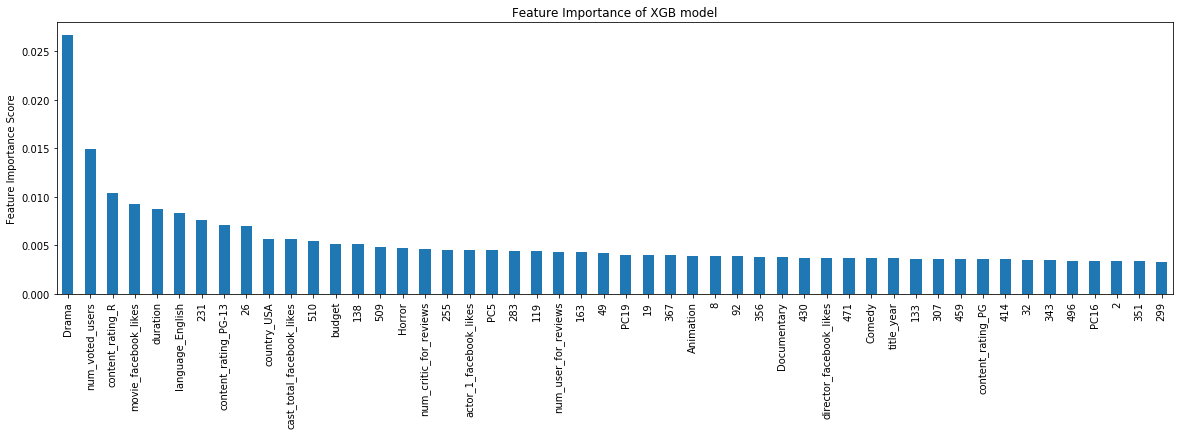

In [46]:
import matplotlib.pyplot as plt
#Feature importance for top 50 predictors
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(grid2.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance of XGB model')
plt.ylabel('Feature Importance Score')

In [ ]:
#round3 randomied XGB - test rmse:  0.7662625394442705

#after tune2
# XGB - test rmse:  0.7652544072121177
#after tune 1
#0.7836648185163719
#base
# XGB - test rmse:  0.7592219053252504
# XGB - test rmse:  0.7565894072382466   #best xgb so far

In [48]:
feat_imp


Drama                        0.026657
num_voted_users              0.014918
content_rating_R             0.010418
movie_facebook_likes         0.009266
duration                     0.008757
language_English             0.008339
231                          0.007662
content_rating_PG-13         0.007096
26                           0.007057
country_USA                  0.005687
cast_total_facebook_likes    0.005665
510                          0.005509
budget                       0.005174
138                          0.005128
509                          0.004846
Horror                       0.004722
num_critic_for_reviews       0.004646
255                          0.004509
actor_1_facebook_likes       0.004502
PC5                          0.004499
283                          0.004442
119                          0.004441
num_user_for_reviews         0.004335
163                          0.004335
49                           0.004215
PC19                         0.004015
19          

In [18]:
# pip install graphviz

Note: you may need to restart the kernel to use updated packages.


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

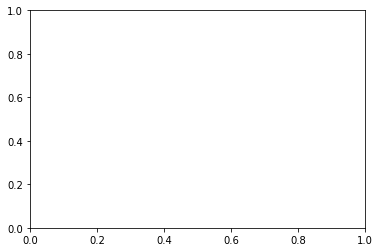

In [21]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
plot_tree(m_xgb2)
plt.show()

In [20]:
import graphviz